In [1]:
import json
import os
from typing import Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [222]:
GROUP_MAP = {
    "detectable_format:number_bullet_lists": "bullet_lists",
    "length_constraints:number_words": "length_constraints",
    "length_constraints:number_sentences": "length_constraints",
    "length_constraints:number_paragraphs": "length_constraints",
    "keywords:forbidden_words": "keywords",
    "keywords:existence": "keywords",
    "change_case:english_capital": "change_case",
    "change_case:english_lowercase": "change_case",
    "detectable_format:json_format": "json_format",
    "startend:quotation": "wrapping",
    "detectable_format:title": "wrapping",
    "combination:repeat_prompt": "startend",
    "startend:end_checker": "startend",
}
GROUP_MAP = {k.replace(':', '_'): v for k, v in GROUP_MAP.items()}

GROUP_MAP_CEQ = {
    "change_case:english_capital": "change_case",
    "change_case:english_lowercase": "change_case",
    "detectable_format:json_format": "json_format",
    "startend:quotation": "wrapping",
    "detectable_format:title": "wrapping",
    "combination:repeat_prompt": "startend",
    "startend:end_checker": "startend",
}
GROUP_MAP_CEQ = {k.replace(':', '_'): v for k, v in GROUP_MAP_CEQ.items()}

GROUP_MAP_CW = {
    "detectable_format:number_bullet_lists": "bullet_lists",
    "length_constraints:number_words": "length_constraints",
    "length_constraints:number_sentences": "length_constraints",
    "length_constraints:number_paragraphs": "length_constraints",
    "keywords:forbidden_words": "keywords",
    "keywords:existence": "keywords",
}
GROUP_MAP_CW = {k.replace(':', '_'): v for k, v in GROUP_MAP_CW.items()}

MAP_AUDIO_TASK = {
    "ASR": "Automatic_speech_recognition",
    "SER": "Speech_emotion_recognition",
    "GR": "Gender_recognition",
    # "MMAU": "MMAU", # not implemented yet
}

MAP_MODEL_NAME = {
    "qwen": "Qwen-Audio",
    "qwen2": "Qwen2-Audio",
    "blsp-emo": "BLSP-Emo",
    "desta2_5": "DeSTA2.5-Audio",
}

MODEL_ORDER = list(MAP_MODEL_NAME.keys())
GROUP_ORDER_CEQ = ["change_case", "startend", "wrapping", "json_format"]
GROUP_ORDER_CW = ["bullet_lists", "keywords", "length_constraints"]

In [220]:
df_audio_task_ceq = {}
for audio_task in ["ASR", "GR", "SER"]:
    df_audio_task_ceq[audio_task] = pd.read_excel(f"./analysis/summary_ceq.xlsx", sheet_name=f"{audio_task}_grouped")

df_audio_task_cot = {}
for audio_task in ["ASR", "GR", "SER"]:
    df_audio_task_cot[audio_task] = pd.read_excel(f"./analysis/summary_CoT.xlsx", sheet_name=audio_task)

df_audio_task_cw = {}
for audio_task in ["ASR", "GR", "SER"]:
    df_audio_task_cw[audio_task] = pd.read_excel(f"./analysis/summary_cw.xlsx", sheet_name=f"{audio_task}_grouped")

In [ ]:
outs = {}
for k, v in df_audio_task_ceq.items():
    outs[k] = []
    for shot_level in v["shot_level"].unique():
        tmp = v.loc[v["shot_level"].eq(shot_level)].copy()
        tmp["model"] = pd.Categorical(tmp["model"], categories=MODEL_ORDER, ordered=True)
        tmp["IF_task_group"] = pd.Categorical(tmp["IF_task_group"], categories=GROUP_ORDER_CEQ, ordered=True)

        out = tmp.pivot_table(
            index="model",
            columns="IF_task_group",
            values="if_rate_strict",
            aggfunc="mean",
            observed=False,
            sort=False,
        )
        outs[k].append(out)

In [141]:
DF_audio_task_ceq = pd.concat(
    list(df_audio_task_ceq.values()),
    keys=list(df_audio_task_ceq.keys()),
    names=["audio_task"]
).reset_index()

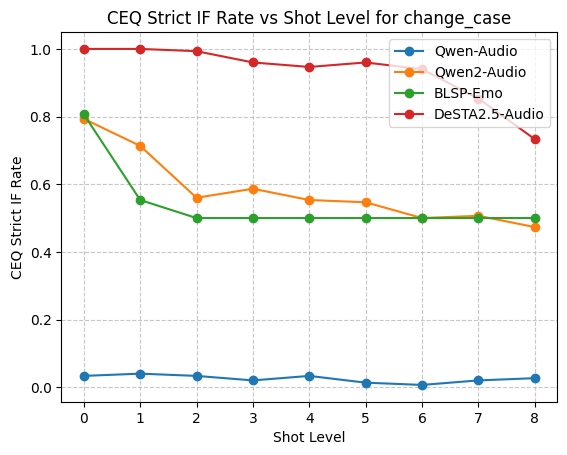

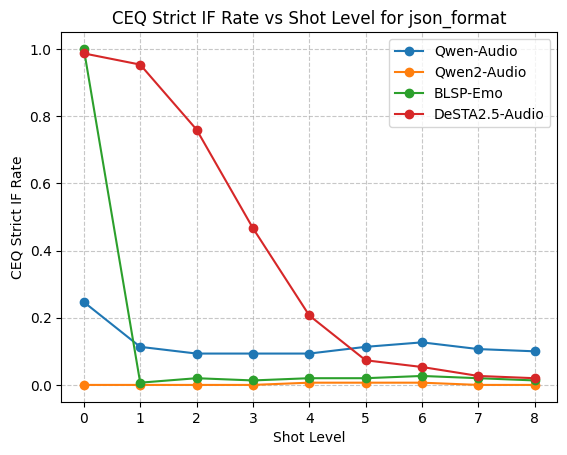

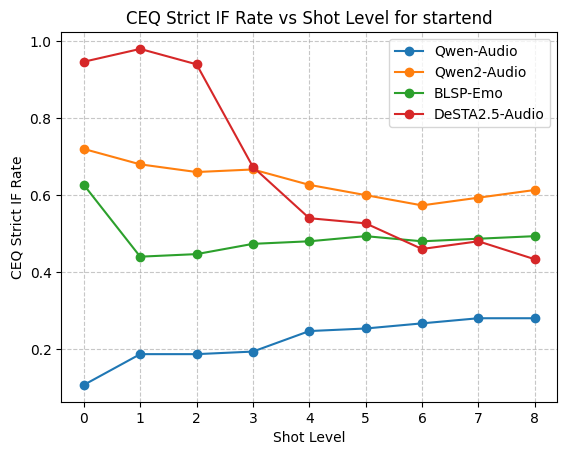

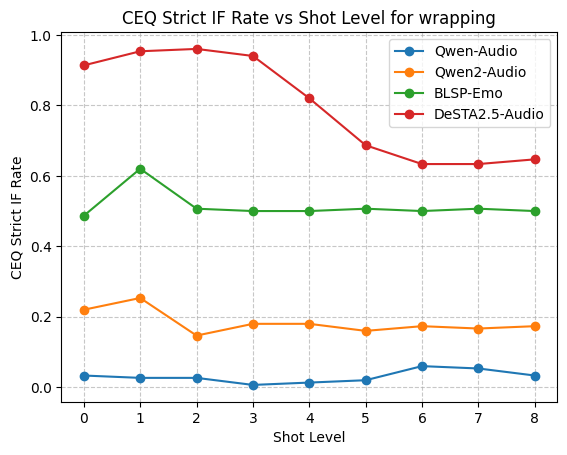

In [216]:
DF_ceq = DF_audio_task_ceq.groupby(["IF_task_group", "model", "shot_level"]).mean(numeric_only=True).reset_index()
DF_ceq["model"] = pd.Categorical(DF_ceq["model"], categories=MODEL_ORDER, ordered=True)
DF_ceq["IF_task_group"] = pd.Categorical(DF_ceq["IF_task_group"], categories=GROUP_ORDER_CEQ, ordered=True)
for group in list(DF_ceq["IF_task_group"].unique()):
#     plt.figure(figsize=(8, 5))
    for model in MODEL_ORDER:
        sub_tmp = DF_ceq[(DF_ceq["IF_task_group"] == group) & (DF_ceq["model"] == model)]
        plt.plot(
            sub_tmp["shot_level"],
            sub_tmp["if_rate_strict"],
            marker='o',
            label=MAP_MODEL_NAME[model]
        )
    plt.title(f"CEQ Strict IF Rate vs Shot Level for {group}")
    plt.xlabel("Shot Level")
    plt.ylabel("CEQ Strict IF Rate")
    plt.xticks(range(9))
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

In [205]:
pt_ceq = DF_ceq.pivot_table(
    index=["model", "shot_level"],
    columns="IF_task_group",
    values="if_rate_strict",
    aggfunc="mean",
    observed=False,
    sort=False,
)
pt_ceq["Avg."] = pt_ceq.mean(axis=1)

In [218]:
pt_0 = pt_ceq.loc[:, 0, :]
pt_k = pt_ceq[pt_ceq.index.get_level_values("shot_level") > 0].groupby("model", observed=False).mean()
tb_ceq = pd.concat([pt_0, pt_k], keys=["Zero-shot", "ICL"], names=["Setting"])
tb_ceq = tb_ceq.swaplevel("Setting", "model").reset_index().sort_values("model").set_index(["model", "Setting"])
round(tb_ceq * 100, 2)


IF_task_group       change_case  startend  wrapping  json_format   Avg.
model    Setting                                                       
qwen     Zero-shot         3.33     10.67      3.33        24.67  10.50
         ICL               2.42     23.67      3.00        10.50   9.90
qwen2    Zero-shot        79.33     72.00     22.00         0.00  43.33
         ICL              55.50     62.67     17.92         0.25  34.08
blsp-emo Zero-shot        80.67     62.67     48.67       100.00  73.00
         ICL              50.67     47.42     51.75         1.75  37.90
desta2_5 Zero-shot       100.00     94.67     91.33        98.67  96.17
         ICL              92.33     62.92     78.42        32.00  66.42

In [ ]:
tb_ceq.to_csv("./analysis/tables_ceq.csv", index=True)

In [236]:
DF_audio_task_cw = pd.concat(
    list(df_audio_task_cw.values()),
    keys=list(df_audio_task_cw.keys()),
    names=["audio_task"]
).reset_index().drop(columns=["level_1"]).dropna()
DF_audio_task_cw["model"] = pd.Categorical(DF_audio_task_cw["model"], categories=MODEL_ORDER, ordered=True)
DF_audio_task_cw["IF_task_group"] = pd.Categorical(DF_audio_task_cw["IF_task_group"], categories=GROUP_ORDER_CW, ordered=True)

pt_cw = DF_audio_task_cw.groupby(["IF_task_group", "model", "shot_level"], observed=False).mean(numeric_only=True)
pt_cw = pt_cw.reset_index().pivot_table(
    index=["model", "shot_level"],
    columns="IF_task_group",
    values="if_rate",
    aggfunc="mean",
    observed=False,
    sort=False,
)
pt_cw["Avg."] = pt_cw.mean(axis=1)

In [238]:
pt_0_cw = pt_cw.loc[:, 0, :]
pt_k_cw = pt_cw[pt_cw.index.get_level_values("shot_level") > 0].groupby("model", observed=False).mean()
tb_cw = pd.concat([pt_0_cw, pt_k_cw], keys=["Zero-shot", "ICL"], names=["Setting"])
tb_cw = tb_cw.swaplevel("Setting", "model").reset_index().sort_values("model").set_index(["model", "Setting"])
tb_cw.to_csv("./analysis/tables_cw.csv", index=True)
round(tb_cw * 100, 2)

IF_task_group       bullet_lists  keywords  length_constraints   Avg.
model    Setting                                                     
qwen     Zero-shot         69.63     51.00               42.09  54.24
         ICL               56.97     63.62               39.36  53.32
qwen2    Zero-shot         86.85     75.00               55.28  72.38
         ICL               77.05     82.62               57.92  72.53
blsp-emo Zero-shot         77.96     57.00               58.78  64.58
         ICL               82.88     55.75               68.45  69.03
desta2_5 Zero-shot         91.02     88.00               81.50  86.84
         ICL               96.16     88.62               90.93  91.90

In [254]:
DF_audio_task_cot = pd.concat(
    list(df_audio_task_cot.values()),
    keys=list(df_audio_task_cot.keys()),
)
DF_audio_task_cot["model"] = pd.Categorical(DF_audio_task_cot["model"], categories=MODEL_ORDER, ordered=True)
pt_cot = DF_audio_task_cot.groupby(["model", "shot_level"], observed=False).mean(numeric_only=True)
pt_cot = pt_cot.reset_index().pivot_table(
    index=["model", "shot_level"],
    values="CoT Acc",
    aggfunc="mean",
    observed=False,
    sort=False,
)

In [255]:
pt_0_cot = pt_cot.loc[:, 0, :]
pt_k_cot = pt_cot[pt_cot.index.get_level_values("shot_level") > 0].groupby("model", observed=False).mean()
tb_cot = pd.concat([pt_0_cot, pt_k_cot], keys=["Zero-shot", "ICL"], names=["Setting"])
tb_cot = tb_cot.swaplevel("Setting", "model").reset_index().sort_values("model").set_index(["model", "Setting"])
tb_cot.to_csv("./analysis/tables_cot.csv", index=True)
round(tb_cot * 100  , 2)

CoT Acc
model    Setting           
qwen     Zero-shot    13.67
         ICL          17.49
qwen2    Zero-shot    28.34
         ICL          57.07
blsp-emo Zero-shot    60.79
         ICL          93.76
desta2_5 Zero-shot    87.07
         ICL          98.09

In [258]:
tb_if = pd.concat([tb_ceq, tb_cw, tb_cot], axis=1, keys=["CEQ", "CW", "CoT"])
tb_if.to_csv("./analysis/tables_if_rate.csv", index=True)
round(tb_if, 2) * 100

CEQ                                      \
                   change_case startend wrapping json_format  Avg.   
model    Setting                                                     
qwen     Zero-shot         3.0     11.0      3.0        25.0  11.0   
         ICL               2.0     24.0      3.0        11.0  10.0   
qwen2    Zero-shot        79.0     72.0     22.0         0.0  43.0   
         ICL              56.0     63.0     18.0         0.0  34.0   
blsp-emo Zero-shot        81.0     63.0     49.0       100.0  73.0   
         ICL              51.0     47.0     52.0         2.0  38.0   
desta2_5 Zero-shot       100.0     95.0     91.0        99.0  96.0   
         ICL              92.0     63.0     78.0        32.0  66.0   

                             CW                                       CoT  
                   bullet_lists keywords length_constraints  Avg. CoT Acc  
model    Setting                                                           
qwen     Zero-shot         70.0     51.0               42.0  54.0    14.0  
         ICL               57.0     64.0               39.0  53.0    17.0  
qwen2    Zero-shot         87.0     75.0               55.0  72.0    28.0  
         ICL               77.0     83.0               58.0  73.0    57.0  
blsp-emo Zero-shot         78.0     57.0               59.0  65.0    61.0  
         ICL               83.0     56.0               68.0  69.0    94.0  
desta2_5 Zero-shot         91.0     88.0               82.0  87.0    87.0  
         ICL               96.0     89.0               91.0  92.0    98.0

In [212]:
avg, std = {}, {}
for k in outs.keys():
    tables = [table for table in outs[k]]
    out = pd.concat(tables, axis=0, keys=list(range(len(tables))), names=["Shot Level"])
    out = out.reorder_levels(["model", "Shot Level"]).sort_index()
    avg[k] = out.mean(axis=1)
    std[k] = out.std(axis=1)

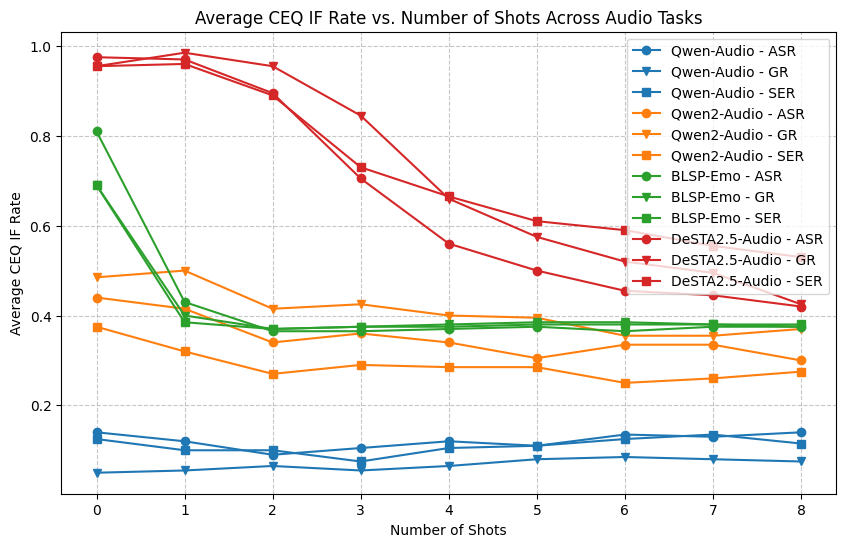

In [214]:
tmp = pd.DataFrame(avg)  # columns: ASR/SER/GR ; index: models ; each cell is a list over shots
# x-axis (0..N-1) based on the length of the first series
shot_levels = list(range(9))
# one color per model (use matplotlib default cycle)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
model_color = {m: colors[i % len(colors)] for i, m in enumerate(MODEL_ORDER)}
# different markers per task
marker_map = {"ASR": "o", "SER": "s", "GR": "v"}  # adjust if your column names differ
plt.figure(figsize=(10, 6))
for model in MODEL_ORDER:
    for audio_task in tmp.columns:
        y = tmp.loc[model, audio_task]
        plt.plot(
            shot_levels, y,
            color=model_color[model],
            marker=marker_map[audio_task],
            label=f"{MAP_MODEL_NAME[model]} - {audio_task}",
        )

plt.legend()
plt.grid(linestyle="--", alpha=0.7)
plt.xlabel("Number of Shots")
plt.ylabel("Average CEQ IF Rate")
plt.title("Average CEQ IF Rate vs. Number of Shots Across Audio Tasks")
plt.show()


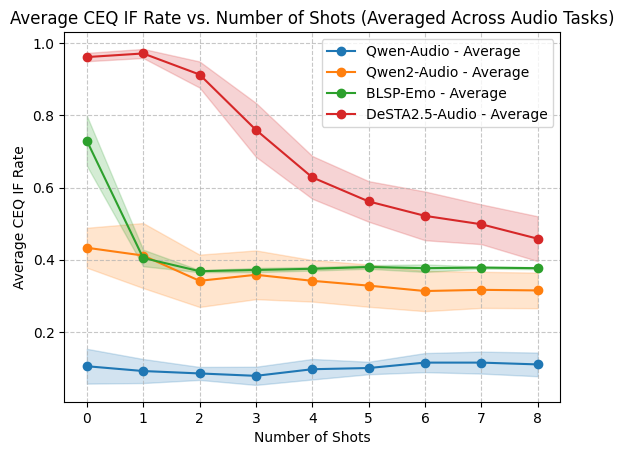

In [215]:
tmp = pd.DataFrame(avg)
avg["avg"] = tmp.mean(axis=1)
std["avg"] = tmp.std(axis=1)
# plt.figure(figsize=(10, 6))
for model in MODEL_ORDER:
    y = avg["avg"][model]
    plt.plot(
        shot_levels, y,
        color=model_color[model],
        marker="o",
        label=f"{MAP_MODEL_NAME[model]} - Average",
    )
    plt.fill_between(
        shot_levels,
        y - std["avg"][model],
        y + std["avg"][model],
        alpha=0.2,
        color=model_color[model],
    )
plt.legend()
plt.grid(linestyle="--", alpha=0.7)
plt.xlabel("Number of Shots")
plt.ylabel("Average CEQ IF Rate")
plt.title("Average CEQ IF Rate vs. Number of Shots (Averaged Across Audio Tasks)")
plt.show()

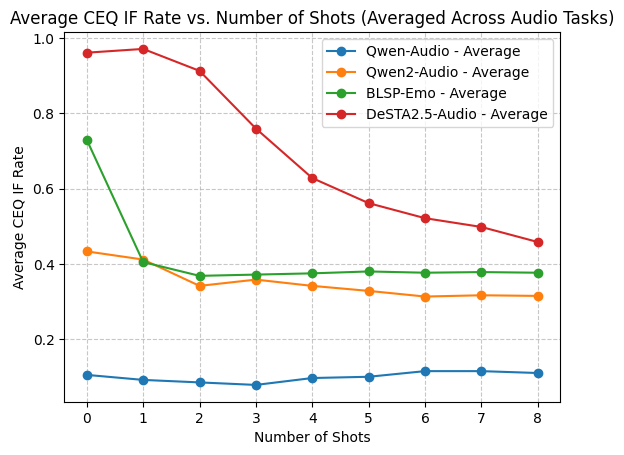

In [217]:
tmp = pd.DataFrame(avg)
avg["avg"] = tmp.mean(axis=1)
std["avg"] = tmp.std(axis=1)
# plt.figure(figsize=(10, 6))
for model in MODEL_ORDER:
    y = avg["avg"][model]
    plt.plot(
        shot_levels, y,
        color=model_color[model],
        marker="o",
        label=f"{MAP_MODEL_NAME[model]} - Average",
    )
plt.legend()
plt.grid(linestyle="--", alpha=0.7)
plt.xlabel("Number of Shots")
plt.ylabel("Average CEQ IF Rate")
plt.title("Average CEQ IF Rate vs. Number of Shots (Averaged Across Audio Tasks)")
plt.show()

In [ ]:
outs = {}
for k, v in df_audio_task_ceq.items():
    outs[k] = []
    for shot_level in v["shot_level"].unique():
        tmp = v.loc[v["shot_level"].eq(shot_level)].copy()
        tmp["model"] = pd.Categorical(tmp["model"], categories=MODEL_ORDER, ordered=True)
        tmp["IF_task_group"] = pd.Categorical(tmp["IF_task_group"], categories=GROUP_ORDER_CEQ, ordered=True)

        out = tmp.pivot_table(
            index="model",
            columns="IF_task_group",
            values="if_rate_strict",
            aggfunc="mean",
            observed=False,
            sort=False,
        )
        outs[k].append(out)

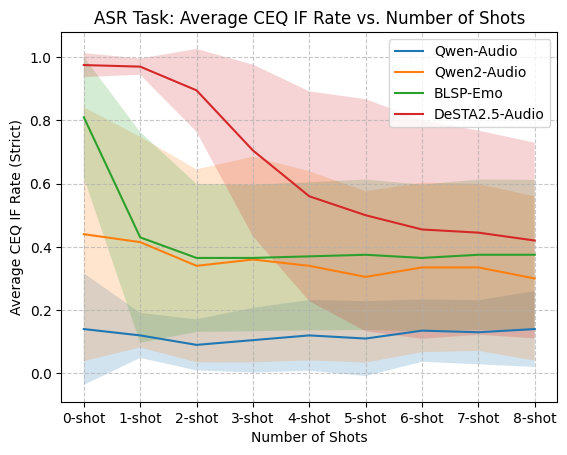

In [ ]:
tables = [table for table in outs["ASR"]]
keys = [f"{k}-shot" for k in range(len(tables))]
out = pd.concat(tables, axis=0, keys=keys, names=["Shot Level"])
out = out.reorder_levels(["model", "Shot Level"]).sort_index()
avg = out.mean(axis=1)
std = out.std(axis=1)

for model in MODEL_ORDER:
    plt.plot(avg[model], label=MAP_MODEL_NAME[model])
    plt.fill_between(avg[model].index, avg[model] - std[model], avg[model] + std[model], alpha=0.2)
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.xlabel("Number of Shots")
plt.ylabel("Average CEQ IF Rate (Strict)")
plt.title("ASR Task: Average CEQ IF Rate vs. Number of Shots")
plt.show()

# creative_writing

In [ ]:
tmp = [v for k, v in df_audio_task_cw.items()]
df_concat = pd.concat(tmp, ignore_index=True)
df_concat = df_concat.dropna()
df_concat = df_concat.groupby(['shot_level', 'IF_task_group', 'model'], observed=False).mean(numeric_only=True).reset_index()
metric_name = 'if_rate'
plot_metric_by_shot_level(
    df_audio_task={'combined': df_concat},
    audio_task='combined',
    response_task="creative_writing",
    IF_task_groups=["bullet_lists", "length_constraints", "keywords"],
    metric_name=metric_name,
)